In [1]:
import os
import sys

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the module from the examples directory
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import networkx as nx
from l2ws.scs_model import SCSmodel, solve_cvxpy_get_params, get_scs_factor
from l2ws.algo_steps import create_projection_fn
from l2ws.utils.generic_utils import setup_permutation
from l2ws.l2ws_helper_fns import train_jitted_epochs

/Users/rajivs/Documents/Princeton/l2ws_conic/env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## SCS

In this tutorial we show how to use our package to learn high-quality warm starts for your favorite fixed-point algorithm.
We consider projected gradient descent to solve the problem

\begin{array}{ll} \text{minimize} & 1 / 2 x^T P x + c^T x
\\ \text{subject to} \quad & Ax + s = b\\
&s \in \mathcal{K}
 \end{array}
where $x \in \mathbf{R}^n$ and $s \in \mathbf{R}^m$ are the decision variables.
Here, $P \in \mathbf{S}_+^n$, $A \in \mathbf{R}^{m \times n}$, $c \in \mathbf{R}^n$, and $b \in \mathbf{R}^m$ are the problem data.


We take the specific example of the semidefinite relaxation to maxcut

\begin{array}{ll} \rm{minimize} &\mathbf{tr}(CX) \\
\text{subject to} &X_{ii} = 1 \quad i=1,\dots,n \\
&X \succeq 0
 \end{array}
where $C \in \mathbf{S}^{n}$ is the problem data.
Here, $\theta = \mathbf{vec}(C)$ is the parameter.

In [2]:
# create the cvxpy problem
n_orig = 10
nc2 = int(n_orig * (n_orig + 1) / 2)
N_train = 5000
N_test = 100
N = N_train + N_test

# create the cvxpy problem
C_param = cp.Parameter((n_orig, n_orig), symmetric=True)
X = cp.Variable((n_orig, n_orig), symmetric=True)
prob = cp.Problem(cp.Maximize(cp.trace(C_param @ X)), constraints=[X >> 0, cp.diag(X) == 1])

In [3]:
# create the C matrices
laplacian_matrices = []
laplacian_matrices_upper_tri_mat = np.zeros((N, nc2))

# Create the nominal graph (you can customize this)
nominal_graph = nx.erdos_renyi_graph(n_orig, 0.5)

probability = 0.2

for i in range(N):
    perturbation_matrix = np.random.rand(n_orig, n_orig) < probability
    perturbation_matrix = (perturbation_matrix + perturbation_matrix.T) / 2

    # Create a graph centered around the nominal graph by combining it with the perturbation
    G = nx.Graph(np.minimum(nx.to_numpy_array(nominal_graph) + perturbation_matrix, 1))

    # Compute the Laplacian matrix of the graph
    laplacian_matrix = nx.laplacian_matrix(G).toarray()
    
    laplacian_matrices.append(laplacian_matrix)
    laplacian_matrices_upper_tri_mat[i, :] = laplacian_matrix[np.triu_indices(laplacian_matrix.shape[0])]

In [4]:
# pass in the cvxpy problem, the cvxpy parameter, and the matrix of parameter values
# returns the optimal solutions, the q vector for all of the problems
#   also returns the cones, P, A
z_stars, q_mat, cones, P, A = solve_cvxpy_get_params(prob, C_param, laplacian_matrices)

m, n = A.shape

In [5]:
M_jax, algo_factor, scale_vec = get_scs_factor(P, A, cones)

In [6]:
q_mat_jax = jnp.array(q_mat) # q = (c, b)
theta_mat_jax = jnp.array(laplacian_matrices_upper_tri_mat)


In [7]:
projection = create_projection_fn(cones, n)
q_mat_train = q_mat_jax[:N_train, :]
q_mat_test = q_mat_jax[N_train:, :]
train_inputs = theta_mat_jax[:N_train, :]
test_inputs = theta_mat_jax[N_train:, :]
z_stars_jax = jnp.array(z_stars)
z_stars_train = z_stars_jax[:N_train, :]
z_stars_test = z_stars_jax[N_train:, :]

train_unrolls = 5
regression = True

nn_cfg = {'intermediate_layer_sizes': [200], 'batch_size': 100}
algo_dict = dict(algorithm='scs',
                      m=m, 
                      n=n, 
                      proj=projection,
                      cones=cones,
                      q_mat_train=q_mat_train, 
                      q_mat_test=q_mat_test,
                      static_M=M_jax,
                      static_algo_factor=algo_factor)
scs_model = SCSmodel(train_unrolls=train_unrolls, 
                     train_inputs=train_inputs, 
                     test_inputs=test_inputs,
                     z_stars_train=z_stars_train,
                     z_stars_test=z_stars_test,
                     regression=regression,
                     nn_cfg=nn_cfg,
                     algo_dict=algo_dict)

In [8]:
# cold start evaluation
eval_iters = 100

# test problems
init_eval_out = scs_model.evaluate(
    eval_iters, test_inputs, q_mat_test, z_stars=z_stars_test, fixed_ws=False)
init_test_losses = init_eval_out[1][1].mean(axis=0)

# train problems
init_eval_train_out = scs_model.evaluate(
    eval_iters, train_inputs, q_mat_train, z_stars=z_stars_train, fixed_ws=False)
init_train_losses = init_eval_train_out[1][1].mean(axis=0)

In [9]:
num_epochs = 200
num_batches = int(N_train / scs_model.batch_size)

permutation = setup_permutation(1, N_train, num_epochs)
params, state, train_losses = train_jitted_epochs(scs_model, permutation, num_batches, num_epochs)
scs_model.params = params
scs_model.state = state


In [15]:
# full evaluation on the test set
final_eval_out = scs_model.evaluate(
    eval_iters, test_inputs, q_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
final_test_losses = final_eval_out[1][1].mean(axis=0)

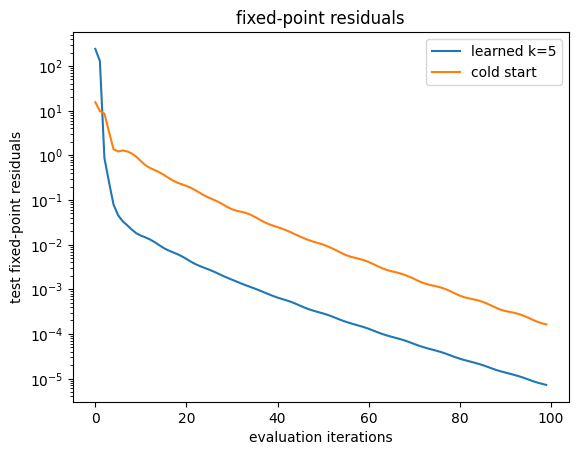

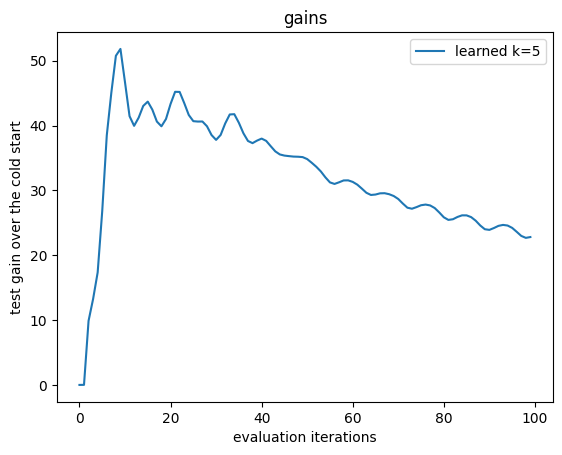

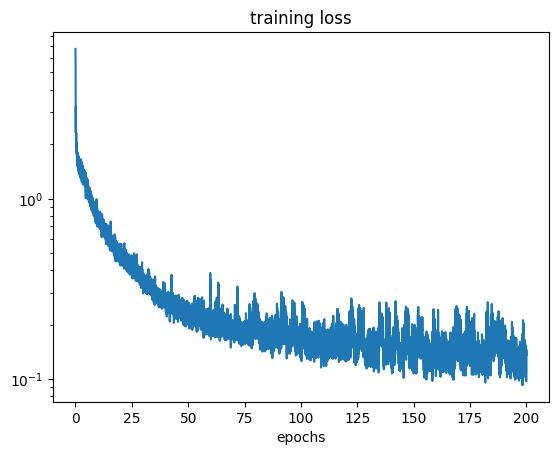

In [16]:
# test results
plt.plot(final_test_losses, label=f"learned k={train_unrolls}")
plt.plot(init_test_losses, label='cold start')
plt.yscale('log')
plt.title('fixed-point residuals')
plt.ylabel('test fixed-point residuals')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

plt.plot(init_test_losses / final_test_losses, label=f"learned k={train_unrolls}")
plt.title('gains')
plt.ylabel('test gain over the cold start')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

batches_per_epoch = N_train / scs_model.batch_size
plt.plot(np.arange(train_losses.size) / batches_per_epoch, train_losses)
plt.yscale('log')
test_losses = np.array([init_test_losses[train_unrolls], final_test_losses[train_unrolls]])
epochs_array = np.array([0, num_epochs])

plt.xlabel('epochs')
plt.yscale('log')
plt.title('training loss')
plt.show()

In [17]:
# run the learned warm starts with SCS code
z0_mat = final_eval_out[1][2][:, 0, :]
final_solve_times_mean = []
final_solve_iters_mean = []

tols = [1e-2, 1e-3, 1e-4, 1e-5]
for i in range(len(tols)):
    rel_tol = tols[i]
    abs_tol = tols[i]
    solve_times, solve_iters, x_sols, y_sols = scs_model.solve_c(z0_mat, q_mat_test, rel_tol, abs_tol)
    final_solve_times_mean.append(solve_times.mean())
    final_solve_iters_mean.append(solve_iters.mean())

In [18]:
# run the cold starts with SCS code
z0_mat = init_eval_out[1][2][:, 0, :]
init_solve_times_mean = []
init_solve_iters_mean = []

for i in range(len(tols)):
    rel_tol = tols[i]
    abs_tol = tols[i]
    solve_times, solve_iters, x_sols, y_sols = scs_model.solve_c(z0_mat, q_mat_test, rel_tol, abs_tol)
    init_solve_times_mean.append(solve_times.mean())
    init_solve_iters_mean.append(solve_iters.mean())

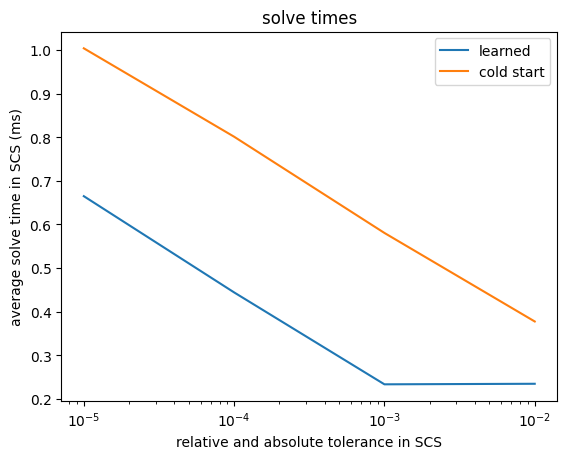

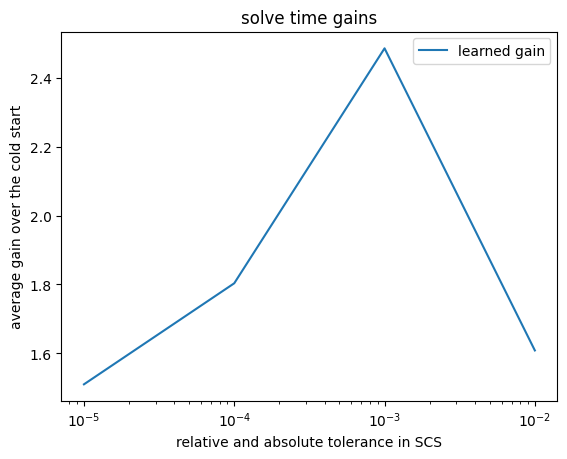

In [19]:
plt.plot(tols, final_solve_times_mean, label='learned')
plt.plot(tols, init_solve_times_mean, label='cold start')
plt.xscale('log')
plt.ylabel('average solve time in SCS (ms)')
plt.xlabel('relative and absolute tolerance in SCS')
plt.title('solve times')
plt.legend()
plt.show()

plt.plot(tols, np.array(init_solve_times_mean) / np.array(final_solve_times_mean), label='learned gain')
plt.xscale('log')
plt.ylabel('average gain over the cold start')
plt.xlabel('relative and absolute tolerance in SCS')
plt.title('solve time gains')
plt.legend()
plt.show()